### **import dependencies**

In [1]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import yaml

from kaggle_secrets import UserSecretsClient
import wandb
from wandb.keras import WandbCallback

import cv2
import pydicom

from pathlib import Path
from tqdm.auto import tqdm

### **configuration and initialization**

In [2]:
SIIM_COVID19_DETECTION_DIR = '/kaggle/input/siim-covid19-detection/'
PART0_RESIZED_DIR = '/kaggle/input/part0-siim-covid19-first-look-resized-512px/'


TEMP_DIR = '/kaggle/temp/'

INPUT_DIR = PART0_RESIZED_DIR+'data/'

OUTPUT_DIR = DATASET_DIR = TEMP_DIR+'data/'
TRAIN_DIR = DATASET_DIR + 'train/'
TA_DIR = TRAIN_DIR+'ta/'
IA_DIR = TRAIN_DIR+'ia/'
AA_DIR = TRAIN_DIR+'aa/'
NP_DIR = TRAIN_DIR+'np/'

WORKING_DIR = '/kaggle/working/'

WANDB_PROJECT_NAME = 'project8-kaggle-covid19'
WANDB_ENTITY_NAME = ''

TRAIN_IMAGE_LEVEL_PATH = SIIM_COVID19_DETECTION_DIR+'train_image_level.csv'
TRAIN_STUDY_LEVEL_PATH = SIIM_COVID19_DETECTION_DIR+'train_study_level.csv'
META_PATH = PART0_RESIZED_DIR+'meta.csv'

BATCH_SIZE = 32
EPOCHS = 25
IMG_SIZE = WIDTH = HEIGHT = 224
LEARNING_RATE = 0.00008

INTERPOLATION = cv2.INTER_LANCZOS4

In [3]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY2")
os.environ['WANDB_API_KEY'] = secret_value_0

os.makedirs(TRAIN_DIR, exist_ok=True)

%cd ../../
%ls

/
bin/   entrypoint.sh*  kaggle/  media/  proc/  run_jupyter.sh*  srv/  usr/
boot/  etc/            lib/     mnt/    root/  sbin/            sys/  var/
dev/   home/           lib64/   opt/    run/   src/             tmp/


In [4]:
wandb.login()

wandb: Currently logged in as: adrien-loridan (use `wandb login --relogin` to force relogin)


True

### **load train/study csv file and merge**

In [5]:
df_train_image_level = pd.read_csv(TRAIN_IMAGE_LEVEL_PATH)
df_train_study_level = pd.read_csv(TRAIN_STUDY_LEVEL_PATH)

df_train_image_level['id'] = df_train_image_level.apply(lambda row: row.id.split('_')[0], axis=1)
df_train_image_level['path'] = df_train_image_level.apply(lambda row: INPUT_DIR+row.id+'.jpg', axis=1)
df_train_image_level['image_level'] = df_train_image_level.apply(lambda row: row.label.split(' ')[0], axis=1)

df_train_study_level['id'] = df_train_study_level.apply(lambda row: row.id.split('_')[0], axis=1)
df_train_study_level.columns = ['StudyInstanceUID', 'Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

In [6]:
df_train_image_level = df_train_image_level.merge(df_train_study_level, on='StudyInstanceUID',how="left")
df_train_image_level = df_train_image_level[['id','StudyInstanceUID','path','Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']]
df_train_image_level = df_train_image_level.dropna()
df_train_image_level = df_train_image_level[~df_train_image_level.duplicated(subset=['StudyInstanceUID'], keep='first')]
df_train_image_level = df_train_image_level.reset_index(drop=True)

### **classification study with VGG16**

**create dir and copy train images in 4 dir classes**

In [7]:
[os.makedirs(dir, exist_ok=True) for dir in [TA_DIR,IA_DIR,AA_DIR,NP_DIR]]
for i in tqdm(range(len(df_train_image_level))):
    row = df_train_image_level.loc[i]
    if row['Typical Appearance']:
        shutil.copy(row.path, f'{TA_DIR}{row.id}.jpg')
    elif row['Indeterminate Appearance']:
        shutil.copy(row.path, f'{IA_DIR}{row.id}.jpg')
    elif row['Atypical Appearance']:
        shutil.copy(row.path, f'{AA_DIR}{row.id}.jpg')
    elif row['Negative for Pneumonia']:
        shutil.copy(row.path, f'{NP_DIR}{row.id}.jpg')
    else:
        print('Error: check df_train_image_level')

  0%|          | 0/6054 [00:00<?, ?it/s]

**datagen / data augmentation**

In [8]:
datagen_kwargs = dict(validation_split=.20,
                      preprocessing_function=preprocess_input
                     )
dataflow_kwargs = dict(target_size=(IMG_SIZE, IMG_SIZE),
                       batch_size=BATCH_SIZE,
                       interpolation="lanczos"
                      )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAIN_DIR,
                                                    subset="validation",
                                                    shuffle=False,
                                                    **dataflow_kwargs)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    **datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    subset="training",
                                                    shuffle=True,
                                                    **dataflow_kwargs)

print('classes :', train_generator.class_indices)

Found 1209 images belonging to 4 classes.
Found 4845 images belonging to 4 classes.
classes : {'aa': 0, 'ia': 1, 'np': 2, 'ta': 3}


**training model vgg16**

In [9]:
tf.keras.backend.clear_session()

wandb.init(project="project8-kaggle-covid19")
config = wandb.config 
config.learning_rate = LEARNING_RATE
config.batch_size = BATCH_SIZE

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers[:15]:
    layer.trainable = False

for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

x = vgg_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x) 

model = tf.keras.Model(inputs=vgg_model.input, outputs=x)

model.build((None, IMG_SIZE, IMG_SIZE, 3))

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

hist = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[WandbCallback(),
              tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
              ]).history

wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


58892288/58889256 [==============================] - 1s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
________________________________________________________________

In [10]:
def plot_confusion_matrix(generator, model, figsize=(15,15)):
    n_steps = len(generator)
    y_true = None
    y_pred = None

    # evaluation
    for step in range(n_steps):
        imgs, labels = next(generator)
        preds = model.predict(imgs)
        preds = np.argmax(preds, axis=1)
        if y_true is None:
            y_true = labels
        if y_pred is None:
            y_pred = preds
        else:
            y_true = np.concatenate((y_true, labels))
            y_pred = np.concatenate((y_pred, preds))

    y_pred = y_pred.astype(np.float64)
    y_true = y_true.astype(np.float64)

    # conversion inverse pour multiclass
    categories = list(generator.class_indices.keys())
    categories_idx = [[element] for element in list(generator.class_indices.values())]
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(categories_idx)
    y_true = onehot_encoder.inverse_transform(y_true)
    y_true = [element[0] for element in y_true]

    fig, ax = plt.subplots(figsize=figsize)
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                           display_labels=categories
                          ).plot(ax=ax,
                                 colorbar=None,
                                 cmap=plt.cm.Blues)
    
    # ameliore l'affichage des labels en pivotants
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)

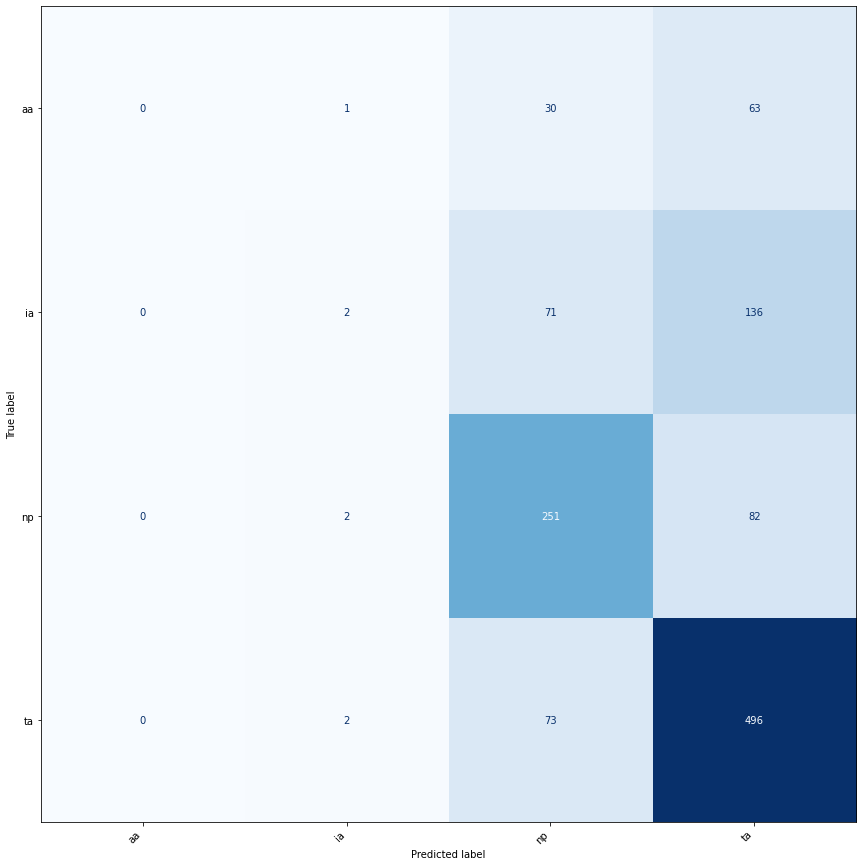

In [11]:
plot_confusion_matrix(valid_generator, model, figsize=(15,15))

### **export**

In [12]:
%cd {WORKING_DIR}
model.save('vgg16')
%cd ../../

/kaggle/working
/
